Philip Fowler
2025 13 06
A notebook to investigate methods for comparing different datasets

# Load libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot
from scipy.optimize import linear_sum_assignment
from statsmodels.tsa.stattools import grangercausalitytests


In [2]:
data = loadmat('data/ExampleDataSet_MonkeyData.mat')

# list keys 
print(data.keys())

# Check the type and shape of each key
for key in data:
    print(f"{key}: type={type(data[key])}", end='')
    if hasattr(data[key], 'shape'):
        print(f", shape={data[key].shape}")
    else:
        print()



dict_keys(['__header__', '__version__', '__globals__', 'SpikeTrains', 'sample_Hz'])
__header__: type=<class 'bytes'>
__version__: type=<class 'str'>
__globals__: type=<class 'list'>
SpikeTrains: type=<class 'numpy.ndarray'>, shape=(12, 1500, 57)
sample_Hz: type=<class 'numpy.ndarray'>, shape=(1, 1)


In [3]:
print(data['sample_Hz'])

[[1000]]


In [4]:
# Extract spike_trains from the loaded data
spike_trains = data['SpikeTrains']

# Create 12 dataframes, one for each trial
for trial_idx in range(spike_trains.shape[0]):
    # Each trial: shape (1500, 57)
    df = pd.DataFrame(spike_trains[trial_idx], columns=[f'neuron{i+1}' for i in range(spike_trains.shape[2])])
    df.index.name = 'time'
    globals()[f'trial{trial_idx+1}_df'] = df


In [5]:
trial1_df.shape

(1500, 57)

In [6]:
trial1_df.head()  

neuron1  neuron2  neuron3  neuron4  neuron5  neuron6  neuron7  neuron8  \
time                                                                           
0           0        0        0        0        0        0        0        0   
1           0        0        0        0        0        0        0        0   
2           0        0        0        0        0        0        0        0   
3           0        0        0        0        0        0        0        0   
4           0        0        0        0        0        0        0        0   

      neuron9  neuron10  ...  neuron48  neuron49  neuron50  neuron51  \
time                     ...                                           
0           0         0  ...         0         0         0         0   
1           0         0  ...         0         0         0         0   
2           0         0  ...         0         0         0         0   
3           0         0  ...         0         0         0         0   
4           0         0  ...         0         0         0         0   

      neuron52  neuron53  neuron54  neuron55  neuron56  neuron57  
time                                                              
0            0         0         0         0         0         0  
1            0         0         0         0         0         0  
2            0         0         0         0         0         0  
3            0         0         0         0         0         0  
4            0         0         0         0         0         0  

[5 rows x 57 columns]

# Exploratory Data Analysis

The first plot here is a raster plot to exampine what a single trial looks like.  

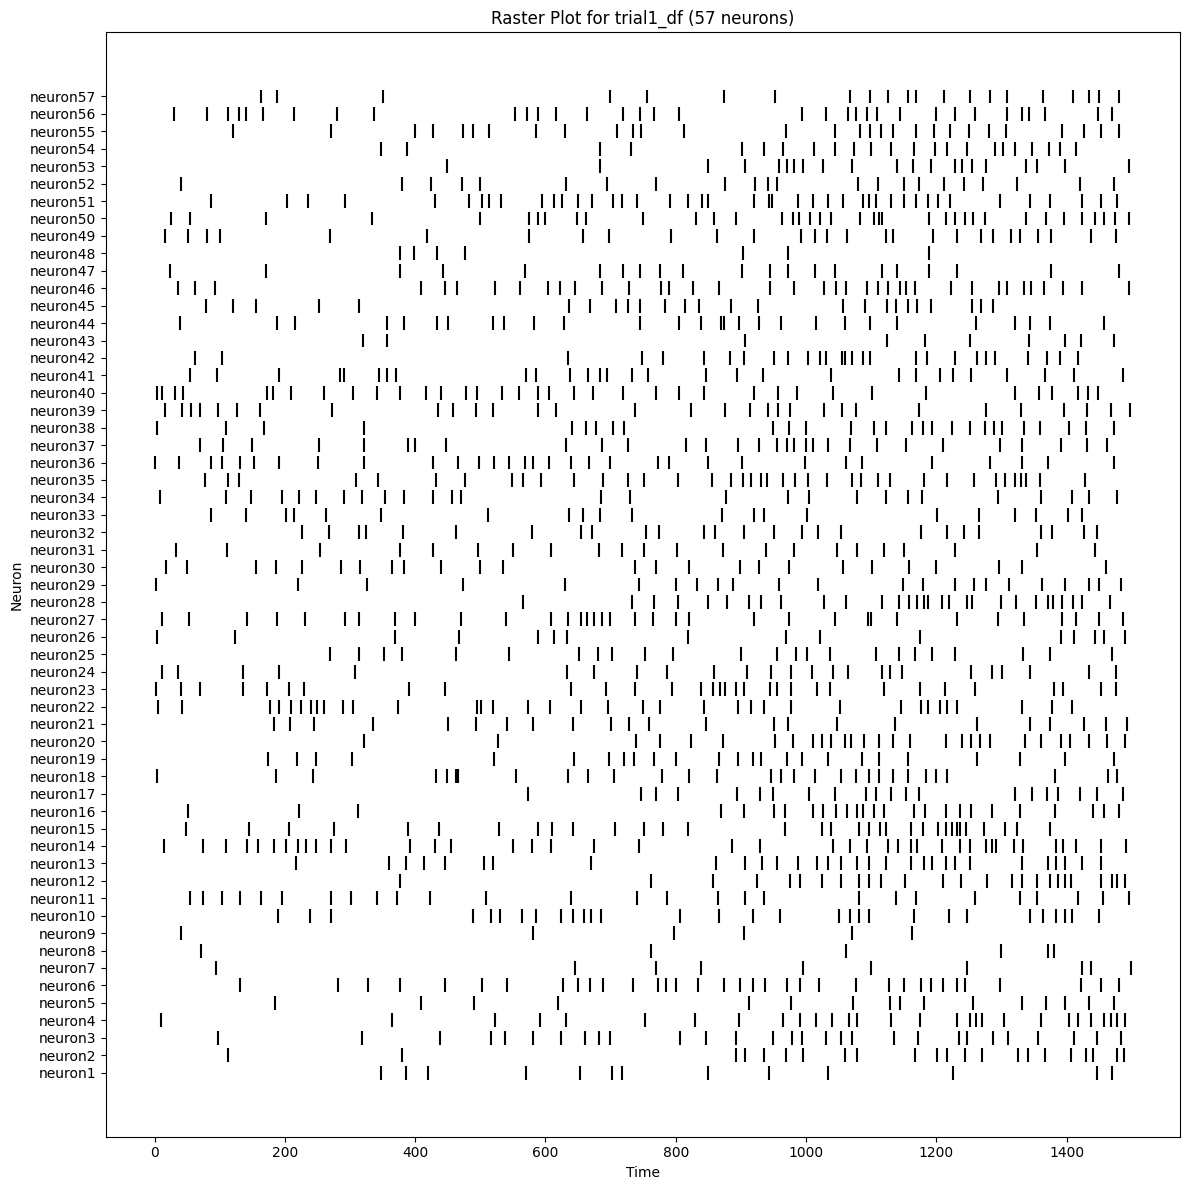

In [7]:
plt.figure(figsize=(12, 12))
spike_times_per_neuron = [trial1_df[neuron].index[trial1_df[neuron] == 1].to_numpy() for neuron in trial1_df.columns]
plt.eventplot(spike_times_per_neuron, orientation='horizontal', colors='black', linelengths=0.8)
plt.yticks(np.arange(57), trial1_df.columns)
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.title('Raster Plot for trial1_df (57 neurons)')
plt.tight_layout()
plt.show()


The plot below is a quick attempt at visualizing how each of the trials compares with other trials.  moving the slider will select a specific neuron and compare it to trial #1.  There are certainly things that could still be improved here.  The colours for example are difficult to distinguish.  

Basically, take this plot as a way to quickly visualize that there are differences.

Some things that we can glean here are that most of the trials are quite similar to trial #1, however, there are a few trials that have bigger differences.  

One thing to notice, you can turn off the individual trial comparisons by clicking on the legend. 

In [ ]:
# note: this cell runs on my laptop; but not on my desktop.  Using plotly express might not be the best option here.
all_neuron_diff_data = []

time_points = globals()["trial1_df"].index.values
num_time_points = len(time_points)

for neuron_idx in range(1, 58): 
    neuron_col_name = f"neuron{neuron_idx}"
    
    current_neuron_trial_data = []
    
    # Check the neuron column 
    if neuron_col_name not in globals()["trial1_df"].columns:
        # print(f"Warning: Column '{neuron_col_name}' not found in trial1_df. Skipping this neuron.")
        continue 

    for i in range(1, 13): 
        df_name = f"trial{i}_df"
        if df_name in globals() and neuron_col_name in globals()[df_name].columns:
            current_neuron_trial_data.append(globals()[df_name][neuron_col_name].values)
        else:
            # print(f"Warning: Could not access '{neuron_col_name}' in '{df_name}'. Skipping this trial for this neuron.")
            pass 

    if not current_neuron_trial_data:
        # print(f"No valid trial data found for {neuron_col_name}. Skipping.")
        continue


    ref_trace_neuron = current_neuron_trial_data[0]
    
    for i, trial_trace in enumerate(current_neuron_trial_data):
        diff = trial_trace - ref_trace_neuron
        
        # Create a temporary 
        temp_df = pd.DataFrame({
            'Time': time_points,
            'Difference': diff,
            'Trial Comparison': f"Trial {i+1} vs Trial 1", 
            'Selected Neuron': f"Neuron {neuron_idx}" 
        })
        all_neuron_diff_data.append(temp_df)

# make master 
if not all_neuron_diff_data:
    print("Error: No data was prepared for plotting. Please ensure your trial_df dataframes and neuron columns are correctly loaded and accessible.")
else:
    master_plot_df = pd.concat(all_neuron_diff_data).reset_index(drop=True)

    master_plot_df['Selected Neuron'] = pd.Categorical(
        master_plot_df['Selected Neuron'],
        categories=[f"Neuron {i}" for i in range(1, 58)], 
        ordered=True
    )

    # animation_frame
    fig = px.line(
        master_plot_df,
        x='Time',
        y='Difference',
        color='Trial Comparison', 
        animation_frame='Selected Neuron', 
        title='Difference Plot Across Trials (relative to Trial 1) for Selected Neuron',
        labels={'Difference': 'Activity Difference', 'Trial Comparison': 'Trial Comparison'},
        height=600 # 
    )


    fig.update_layout(
        xaxis={'range': [0, num_time_points - 1]}, 
        yaxis={'range': [master_plot_df['Difference'].min() * 1.05, master_plot_df['Difference'].max() * 1.05]}, 
        updatemenus=[
            dict(
                type="dropdown",
                direction="down",
                x=0.01,
                y=1.15, 
                showactive=True,
                buttons=list([
                    dict(
                        label=f.replace("Selected Neuron=", ""), 
                        method="animate",
                        args=[
                            [f],
                            dict(
                                mode="immediate",
                                frame=dict(duration=0, redraw=True),
                                transition=dict(duration=0)
                            )
                        ]
                    ) for f in master_plot_df['Selected Neuron'].cat.categories 
                ])
            )
        ]
    )
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

A better way to visualize this is with a raster plot as shown below.  We can see how similar the trials are to one another.

todo: recreate this with plotly with a slider or dropdown for each neuron

The thing to notice is that there's not a lot of comparabiolilty between the trials.

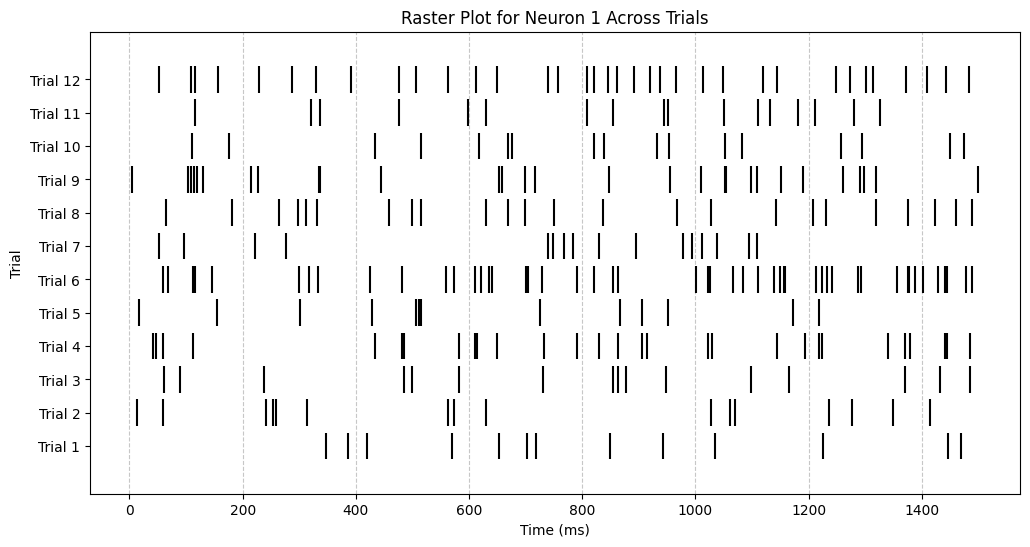

In [9]:
plt.figure(figsize=(12, 6))
for i in range(12): 
    neuron_data = globals()[f"trial{i+1}_df"]['neuron1'].values
    spike_times = np.where(neuron_data == 1)[0] 
    plt.eventplot(spike_times, lineoffsets=i + 1, linelengths=0.8, color='black')

plt.yticks(np.arange(1, 13), [f'Trial {i}' for i in range(1, 13)])
plt.xlabel('Time (ms)')
plt.ylabel('Trial')
plt.title('Raster Plot for Neuron 1 Across Trials')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Even though the trials are dissimilar, I am including histograms .  It seems to me that the better metric for this is going to have something to do with the spacing between the spikes or the number of spikes per time.  Or perhaps a better approach is to look at ways of correlating time series.  Trisha mentioned corss-correlation.  

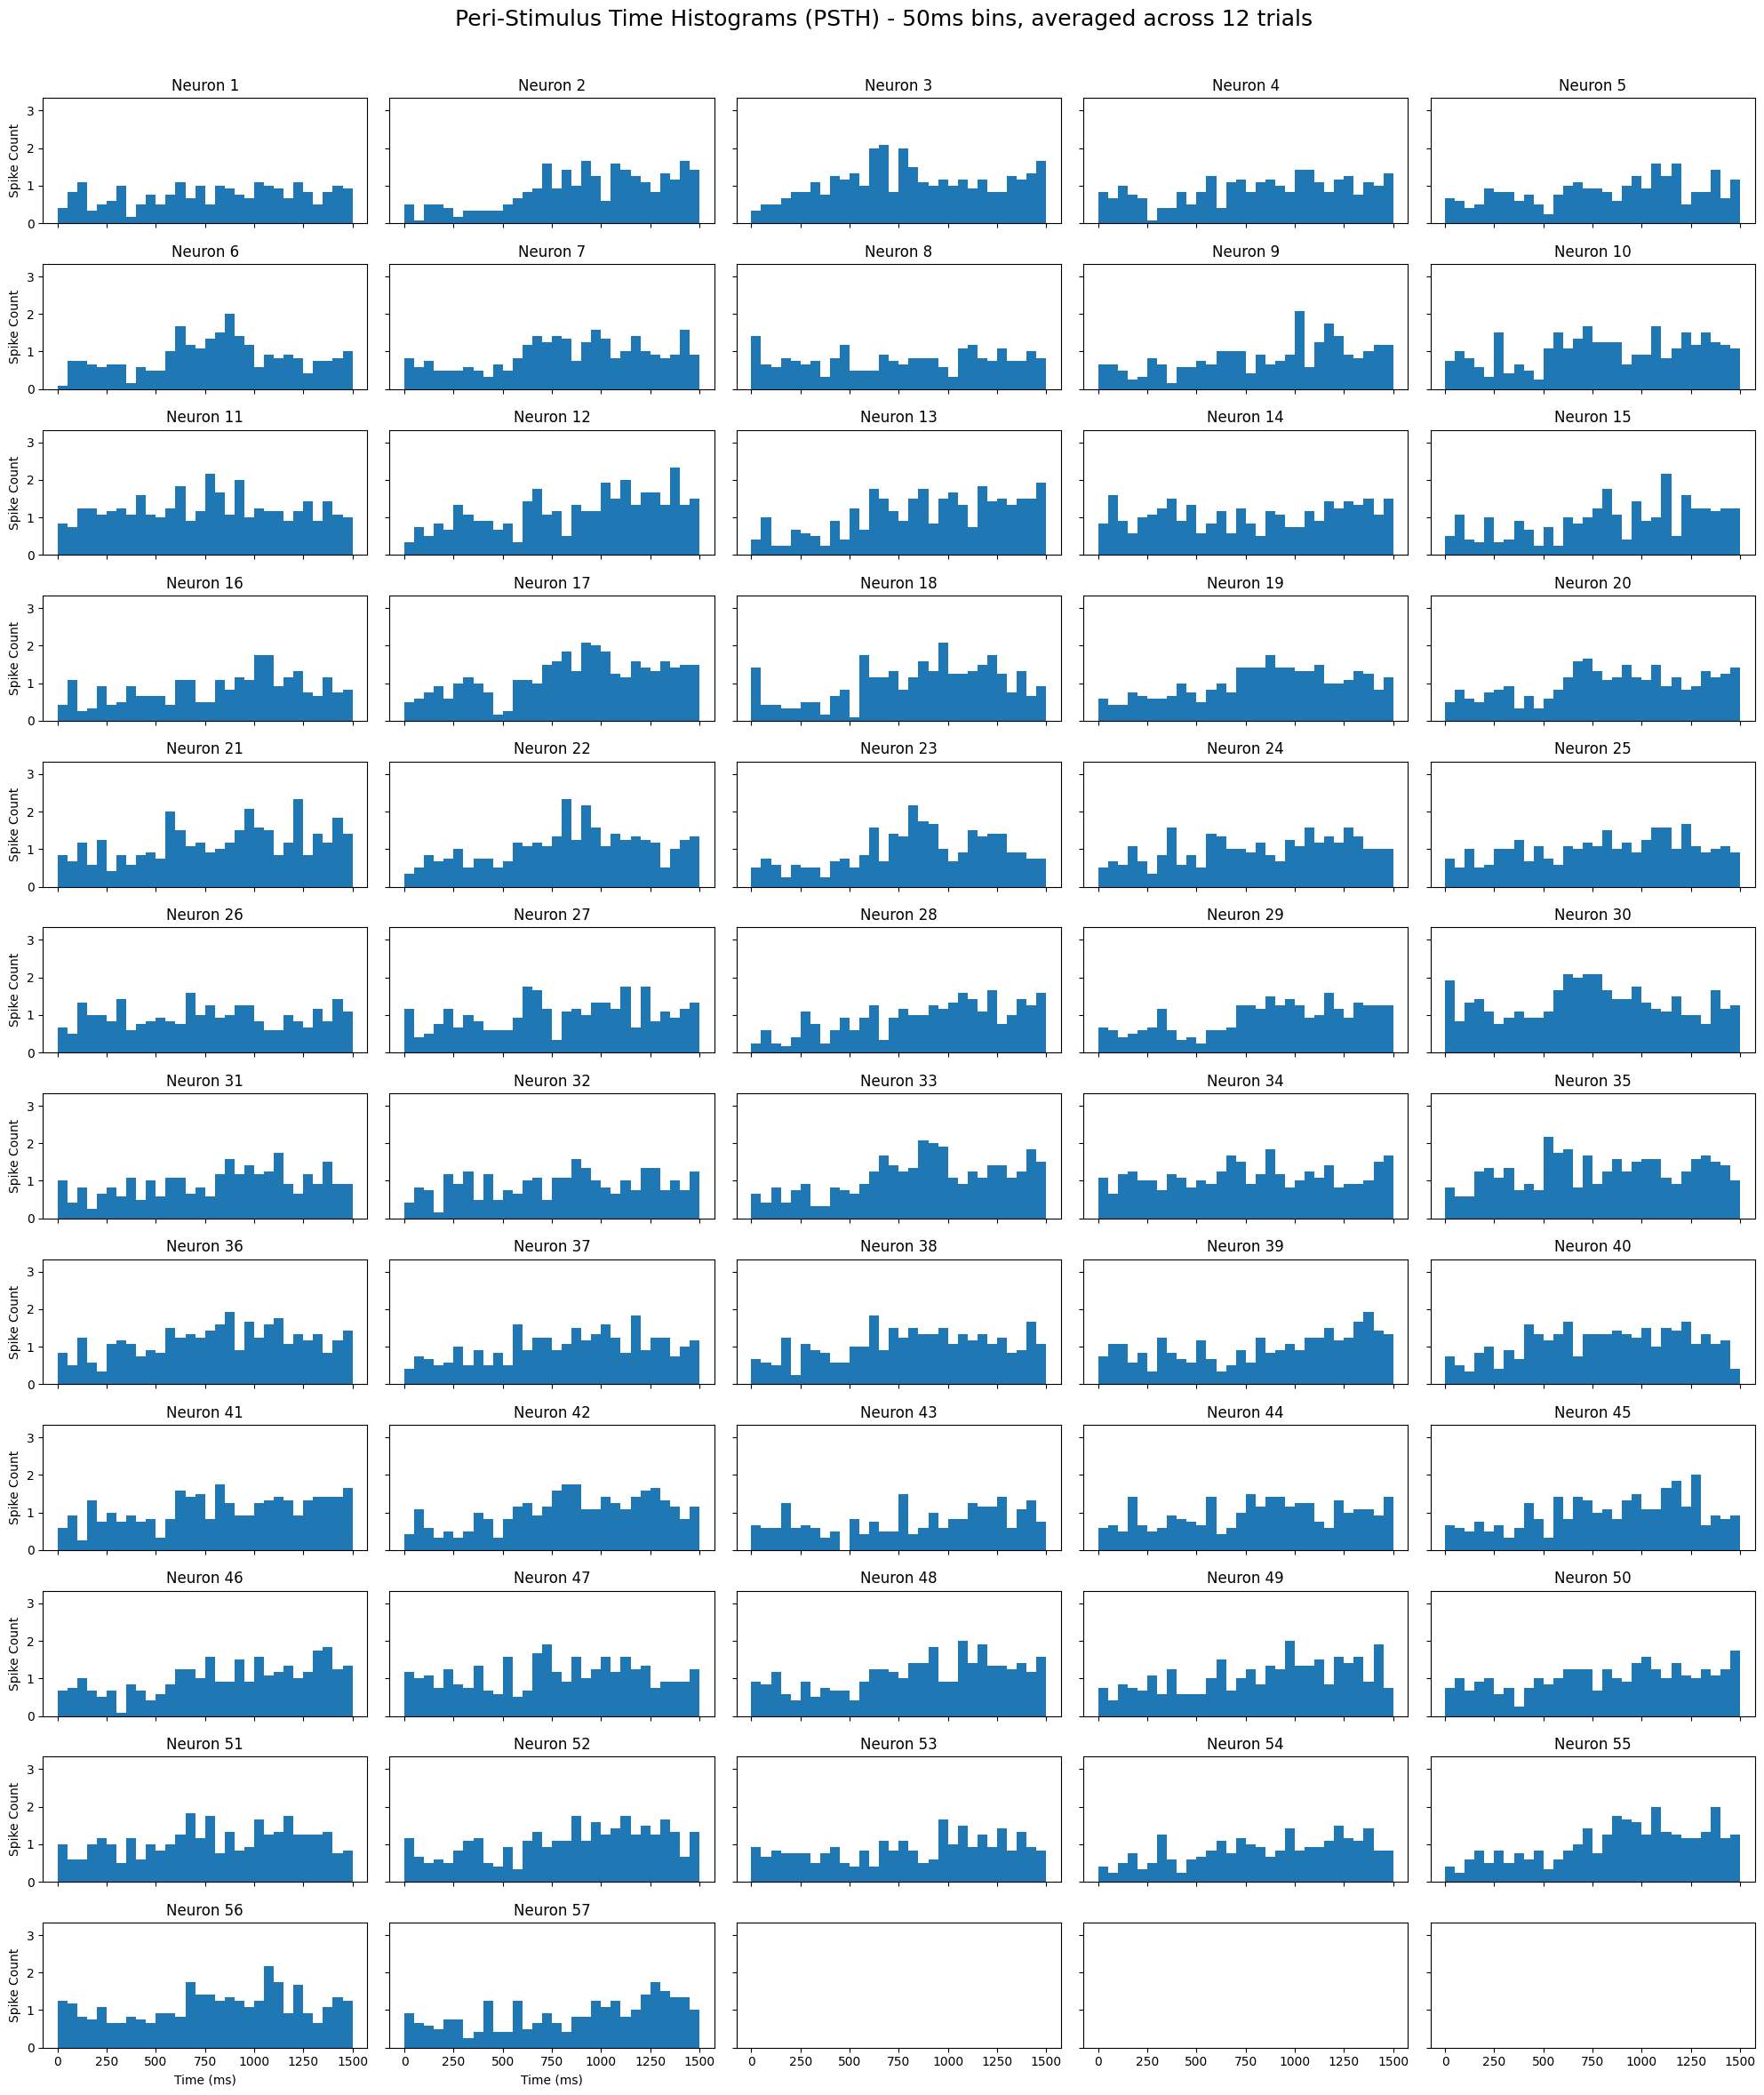

In [10]:
bin_size = 50
num_bins = trial1_df.shape[0] // bin_size

all_trials = [globals()[f"trial{i+1}_df"] for i in range(12)]

binned_counts = []
for trial_df in all_trials:
    arr = trial_df.values[:num_bins*bin_size].reshape(num_bins, bin_size, -1)
    binned = arr.sum(axis=1)
    binned_counts.append(binned)

binned_counts = np.stack(binned_counts, axis=0)

mean_binned_counts = binned_counts.mean(axis=0)

fig, axes = plt.subplots(12, 5, figsize=(20, 24), sharex=True, sharey=True)
axes = axes.flatten()
time_bins = np.arange(num_bins) * bin_size

for i in range(mean_binned_counts.shape[1]):
    axes[i].bar(time_bins, mean_binned_counts[:, i], width=bin_size, align='edge', color='tab:blue')
    axes[i].set_title(f'Neuron {i+1}')
    axes[i].set_ylim(0, mean_binned_counts.max() + 1)
    if i % 5 == 0:
        axes[i].set_ylabel('Spike Count')
    if i >= 55:
        axes[i].set_xlabel('Time (ms)')

plt.suptitle('Peri-Stimulus Time Histograms (PSTH) - 50ms bins, averaged across 12 trials', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

I am still working on the different methods that are used to compare different trials and neurons.  This approach below appeared in several papers that I saw in google scholar.  

The idea here is that we can compare the same neuron across different trials.  The matrix that we get shows how dissemilar each trial is from another trial.  The units aren't shown; however, it is in a time based unit

Note: this is only for a single neuron.  Change the neuron variable below to compare different neurons.
this could also be redone as a plotly plot with a slider to select the neuron.


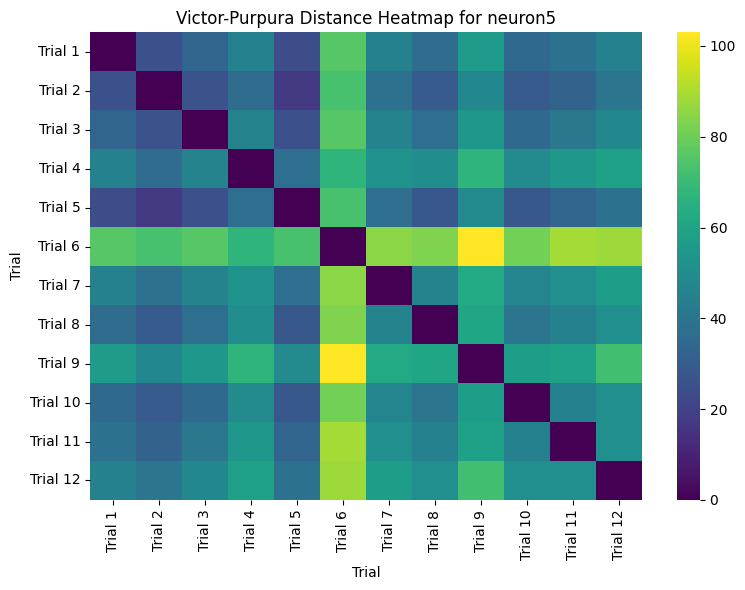

In [11]:
def victor_purpura_distance(trace1, trace2, q=1.0):
    # Convert binary spike trains to spike times
    spike_times1 = np.where(trace1 == 1)[0]
    spike_times2 = np.where(trace2 == 1)[0]
    n = len(spike_times1)
    m = len(spike_times2)
    # Initialize DP matrix
    dp = np.zeros((n+1, m+1))
    dp[:,0] = np.arange(n+1)
    dp[0,:] = np.arange(m+1)
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = q * abs(spike_times1[i-1] - spike_times2[j-1])
            dp[i,j] = min(
                dp[i-1,j] + 1,      # deletion
                dp[i,j-1] + 1,      # insertion
                dp[i-1,j-1] + cost  # shift
            )
    return dp[n,m]

all_trials = [globals()[f"trial{i+1}_df"] for i in range(12)]

vp_distances = {}
for neuron in all_trials[0].columns:
    vp_distances[neuron] = []
    for i in range(len(all_trials)):
        for j in range(i+1, len(all_trials)):
            d = victor_purpura_distance(
                all_trials[i][neuron].values, 
                all_trials[j][neuron].values, 
                q=1.0
            )
            vp_distances[neuron].append({'trial_pair': (i+1, j+1), 'distance': d})

neuron = 'neuron5'
distances = vp_distances[neuron]

trial_numbers = sorted(set([pair['trial_pair'][0] for pair in distances] + [pair['trial_pair'][1] for pair in distances]))
n_trials = max(trial_numbers)

vp_matrix = np.zeros((n_trials, n_trials))
vp_matrix[:] = np.nan  

for entry in distances:
    i, j = entry['trial_pair']
    vp_matrix[i-1, j-1] = entry['distance']
    vp_matrix[j-1, i-1] = entry['distance']  

np.fill_diagonal(vp_matrix, 0)

plt.figure(figsize=(8, 6))
sns.heatmap(vp_matrix, annot=False, cmap='viridis', xticklabels=[f'Trial {i+1}' for i in range(n_trials)], yticklabels=[f'Trial {i+1}' for i in range(n_trials)])
plt.title(f'Victor-Purpura Distance Heatmap for {neuron}')
plt.xlabel('Trial')
plt.ylabel('Trial')
plt.tight_layout()
plt.show()


# Finding Correlations

So, it seems to me that one of the most important things to find here is correlations between the neurons.  

In our previous examples we had 5 neurons and a diagram of how they were connected.  Here we hat 57 neurons, can correlations be found to elucidate which neurons might be connected?

Granger causality is a method that we can use here.  The gist of the idea is that we can use one neuron's time series to predict another.  

Some things to notice.  This heatmap is not symetrical across the diagonal.  This should make sense as neuron1 appears to have some value in predicting neuron18; however, the inverse is not the same.

In [13]:
max_lag = 5  
granger_results = {}

for source_idx in range(57):
    for target_idx in range(57):
        if source_idx == target_idx:
            continue  
        source = f'neuron{source_idx+1}'
        target = f'neuron{target_idx+1}'
        key = (source, target)
        granger_results[key] = []
        for trial_num in range(1, 13):
            df = globals()[f"trial{trial_num}_df"]
            data = df[[target, source]].astype(float).values
            try:
                test_result = grangercausalitytests(data, maxlag=max_lag)
                min_pvalue = min([test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag+1)])
                granger_results[key].append(min_pvalue)
            except Exception as e:
                granger_results[key].append(np.nan)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2009  , p=0.6541  , df_denom=1496, df_num=1
ssr based chi2 test:   chi2=0.2013  , p=0.6537  , df=1
likelihood ratio test: chi2=0.2013  , p=0.6537  , df=1
parameter F test:         F=0.2009  , p=0.6541  , df_denom=1496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2089  , p=0.8115  , df_denom=1493, df_num=2
ssr based chi2 test:   chi2=0.4191  , p=0.8109  , df=2
likelihood ratio test: chi2=0.4191  , p=0.8110  , df=2
parameter F test:         F=0.2089  , p=0.8115  , df_denom=1493, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2174  , p=0.8844  , df_denom=1490, df_num=3
ssr based chi2 test:   chi2=0.6552  , p=0.8837  , df=3
likelihood ratio test: chi2=0.6550  , p=0.8837  , df=3
parameter F test:         F=0.2174  , p=0.8844  , df_denom=1490, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2264  , p=0.

KeyboardInterrupt: 

In [ ]:
# The above cell takes a while to run.  Plotting is in a separate cell to make my life easier.
avg_p_values_matrix = np.full((num_neurons, num_neurons), np.nan)

neuron_names = [f'neuron{i+1}' for i in range(num_neurons)]
neuron_to_idx = {name: i for i, name in enumerate(neuron_names)}

for (source, target), p_values in granger_results.items():

    avg_p = np.nanmean(p_values)
    if np.isnan(avg_p): 
        continue

    target_idx = neuron_to_idx[target]
    source_idx = neuron_to_idx[source]

    avg_p_values_matrix[target_idx, source_idx] = avg_p

granger_df = pd.DataFrame(avg_p_values_matrix, index=neuron_names, columns=neuron_names)

plt.figure(figsize=(12, 10)) 
sns.heatmap(granger_df, cmap='viridis_r', annot=False, fmt=".2f",
            linewidths=.5, linecolor='lightgray', cbar_kws={'label': 'Average P-value'})

plt.title('Average Granger Causality P-values Between Neuron Pairs', fontsize=16)
plt.xlabel('Source Neuron', fontsize=12)
plt.ylabel('Target Neuron', fontsize=12)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout() 
plt.show()



In [14]:
max_lag = 5  
granger_results = {}

df = trial1_df  # This can be changed to other trials  

for source_idx in range(57):
    for target_idx in range(57):
        if source_idx == target_idx:
            continue  
        source = f'neuron{source_idx+1}'
        target = f'neuron{target_idx+1}'
        key = (source, target)
        try:
            data = df[[target, source]].astype(float).values
            test_result = grangercausalitytests(data, maxlag=max_lag)
            min_pvalue = min([test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag+1)])
            granger_results[key] = min_pvalue
        except Exception as e:
            granger_results[key] = np.nan



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2009  , p=0.6541  , df_denom=1496, df_num=1
ssr based chi2 test:   chi2=0.2013  , p=0.6537  , df=1
likelihood ratio test: chi2=0.2013  , p=0.6537  , df=1
parameter F test:         F=0.2009  , p=0.6541  , df_denom=1496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2089  , p=0.8115  , df_denom=1493, df_num=2
ssr based chi2 test:   chi2=0.4191  , p=0.8109  , df=2
likelihood ratio test: chi2=0.4191  , p=0.8110  , df=2
parameter F test:         F=0.2089  , p=0.8115  , df_denom=1493, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2174  , p=0.8844  , df_denom=1490, df_num=3
ssr based chi2 test:   chi2=0.6552  , p=0.8837  , df=3
likelihood ratio test: chi2=0.6550  , p=0.8837  , df=3
parameter F test:         F=0.2174  , p=0.8844  , df_denom=1490, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2264  , p=0.

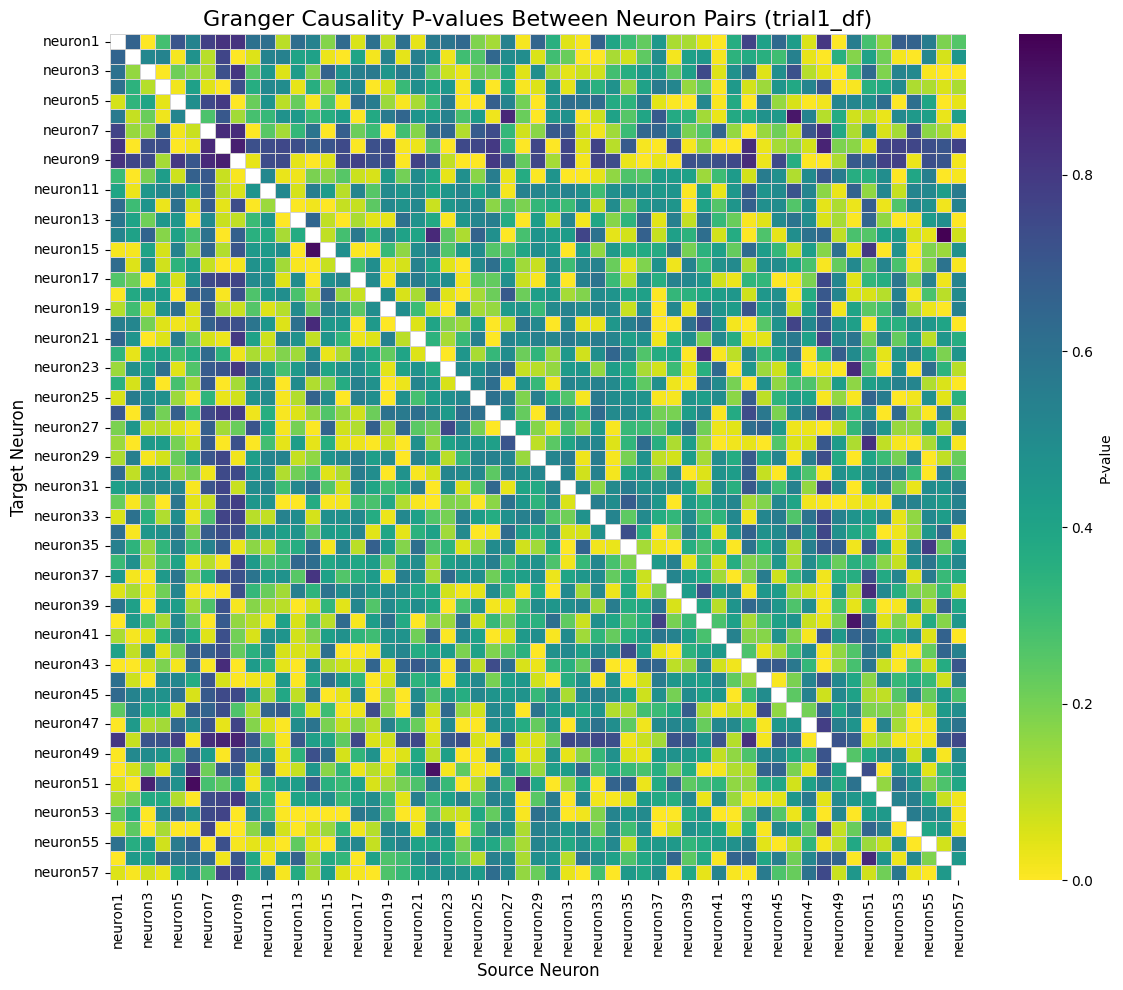

In [ ]:
# Heatmap time!
num_neurons = 57
neuron_names = [f'neuron{i+1}' for i in range(num_neurons)]
neuron_to_idx = {name: i for i, name in enumerate(neuron_names)}

p_values_matrix = np.full((num_neurons, num_neurons), np.nan)

for (source, target), p_value in granger_results.items():
    target_idx = neuron_to_idx[target]
    source_idx = neuron_to_idx[source]
    p_values_matrix[target_idx, source_idx] = p_value

granger_df = pd.DataFrame(p_values_matrix, index=neuron_names, columns=neuron_names)

plt.figure(figsize=(12, 10))
sns.heatmap(granger_df, cmap='viridis_r', annot=False, fmt=".2f",
            linewidths=.5, linecolor='lightgray', cbar_kws={'label': 'P-value'})

plt.title('Granger Causality P-values Between Neuron Pairs (trial1_df)', fontsize=16)
plt.xlabel('Source Neuron', fontsize=12)
plt.ylabel('Target Neuron', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
